# Set up

In [16]:
from wsi import filter
from wsi import slide
from wsi import util
%matplotlib inline

In [17]:
# Replace with WSI file path!
FILE = 'data/U.svs'

RGB                  | Time: 0:00:00.001708  Type: uint8   Shape: (816, 933, 3)


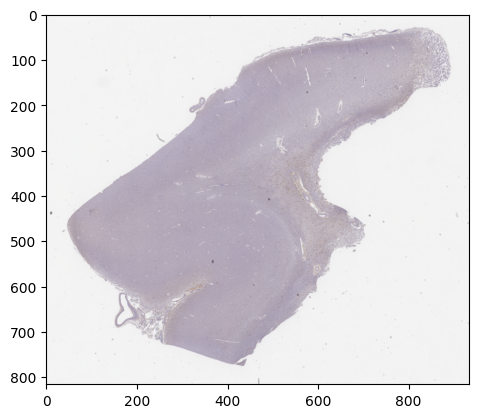

In [18]:
np_img = slide.slide_to_scaled_np_image(FILE, 32)
util.display_img(np_img)

# Complement + Otsu

Gray                 | Time: 0:00:00.049793  Type: uint8   Shape: (816, 933)
Complement           | Time: 0:00:00.000209  Type: uint8   Shape: (816, 933)


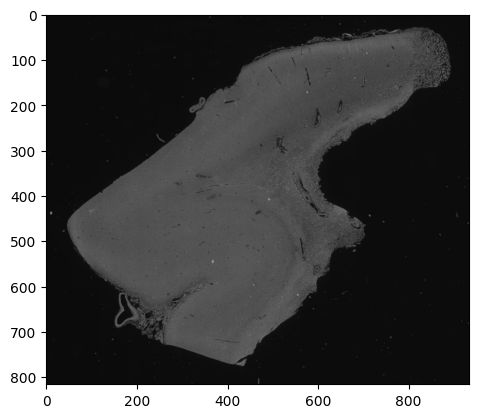

In [19]:
t = util.Time()
grayscale = filter.filter_rgb_to_grayscale(np_img)
complement = filter.filter_complement(grayscale)
util.display_img(complement)

Otsu Threshold       | Time: 0:00:00.005494  Type: uint8   Shape: (816, 933)


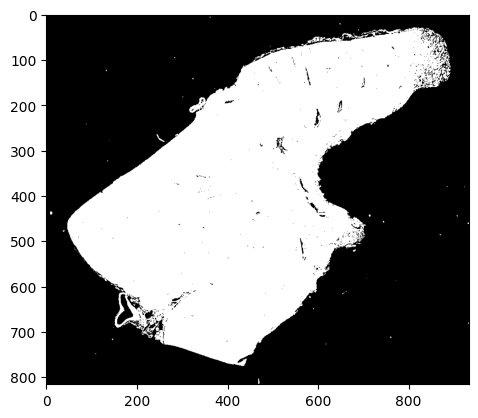

In [20]:
otsu = filter.filter_otsu_threshold(complement)
util.display_img(otsu)
otsu_time = t.elapsed()

Mask RGB             | Time: 0:00:00.003255  Type: uint8   Shape: (816, 933, 3)


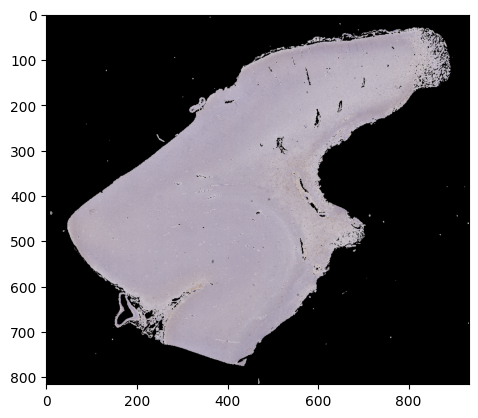

In [21]:
util.display_img(util.mask_rgb(np_img, otsu))

# Median + Saturation + Otsu + Dilation

Source: [A generalized deep learning framework for whole-slide image segmentation and analysis](https://www.nature.com/articles/s41598-021-90444-8)

Median filtering on RGB image

Median               | Time: 0:00:00.640182  Type: uint8   Shape: (816, 933, 3)


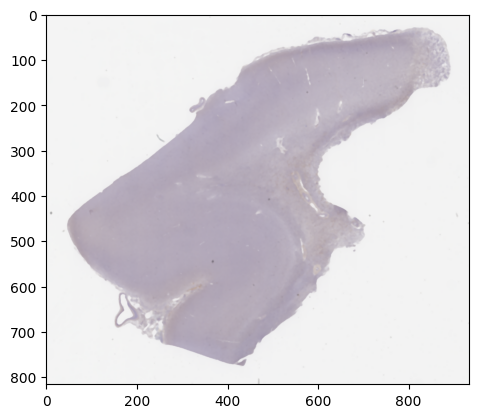

In [22]:
t = util.Time()
md = filter.filter_median(np_img, size=5)
util.display_img(md)

RGB to HSV           | Time: 0:00:00.145341  Type: float64 Shape: (816, 933, 3)


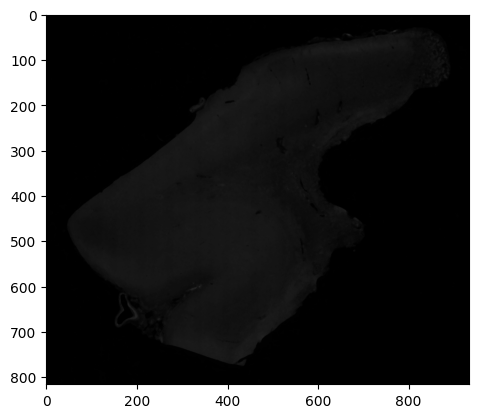

In [23]:
saturation = filter.filter_rgb_to_hsv(md)[:, :, 1]
util.display_img(saturation)

Otsu Threshold       | Time: 0:00:00.013964  Type: uint8   Shape: (816, 933)


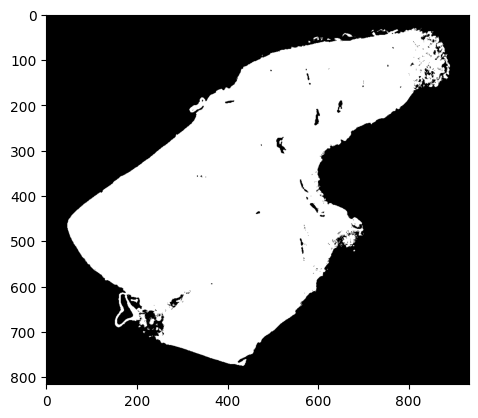

In [24]:
otsu = filter.filter_otsu_threshold(saturation)
util.display_img(otsu)

Binary Dilation      | Time: 0:00:00.046531  Type: uint8   Shape: (816, 933)


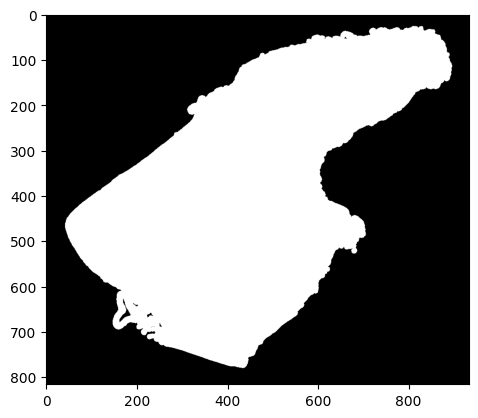

In [25]:
dilation = filter.filter_binary_dilation(otsu, disk_size=5)
util.display_img(dilation)
msod_time = t.elapsed()

Mask RGB             | Time: 0:00:00.003298  Type: uint8   Shape: (816, 933, 3)


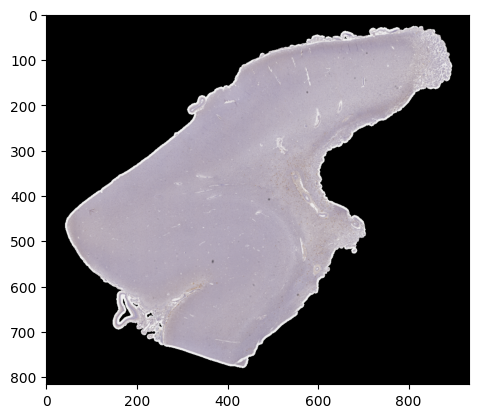

In [26]:
util.display_img(util.mask_rgb(np_img, dilation))

# Entropy Masker

Source: [An automatic entropy method to efficiently mask histology whole-slide images](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10017682/)

Gray                 | Time: 0:00:00.054375  Type: uint8   Shape: (816, 933)


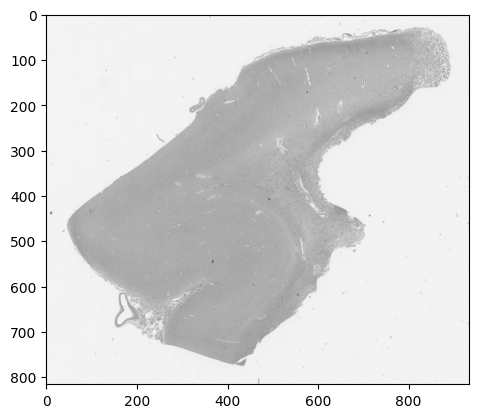

In [27]:
t = util.Time()
grayscale = filter.filter_rgb_to_grayscale(np_img)
util.display_img(grayscale)

Entropy              | Time: 0:00:00.356513  Type: uint8   Shape: (816, 933)


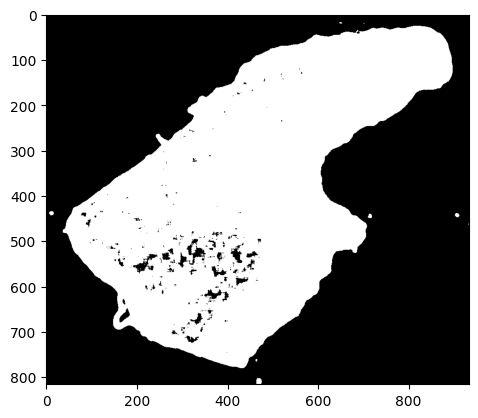

In [28]:
entropy = filter.filter_entropy(grayscale, neighborhood=12, threshold=3)
util.display_img(entropy)
entropy_time = t.elapsed()

Mask RGB             | Time: 0:00:00.003249  Type: uint8   Shape: (816, 933, 3)


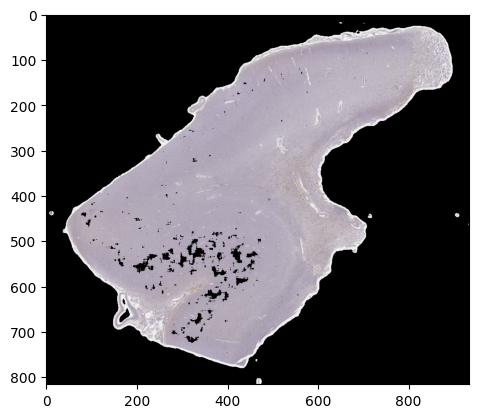

In [29]:
util.display_img(util.mask_rgb(np_img, entropy))

# Performance Comparison

In [30]:
import pandas as pd
data = [["Otsu", str(otsu_time)],
        ["Median + Saturation + Otsu + Dilation", str(msod_time)], 
        ["Entropy", str(entropy_time)]]
table = pd.DataFrame(data, columns=["Method", "Runtime"])
display(table)

,Method,Runtime
0,Otsu,0:00:00.238155
1,Median + Saturation + Otsu + Dilation,0:00:01.365242
2,Entropy,0:00:00.593097
